In [1]:
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pyfolio as pf

warnings.filterwarnings('ignore')

D:\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
end_date = datetime.date.today()
start_date = end_date - pd.Timedelta(days = 365*10)
lookback = 30
std_dev = 1.5

portfolio = pd.DataFrame()
# pairs = {'pair1': ['ACC.NS', 'AMBUJACEM.NS'], 'pair2': ['EWC', 'EWA'], 'pair3': ['KOTAKBANK.NS', 'HDFCBANK.NS']}
pairs = {'pair1': ['ACC.NS', 'AMBUJACEM.NS'], 'pair2': ['KOTAKBANK.NS', 'HDFCBANK.NS']}

In [3]:
def download_daily_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
    return data

In [4]:
def manipulate_data(data_ticker_1, data_ticker_2, ticker_1, ticker_2):
    data = pd.concat([data_ticker_1, data_ticker_2], axis=1)
    data.columns = [ticker_1, ticker_2]
    df = data.copy()
    return data, df

In [5]:
def calculate_spread(data, ticker_1, ticker_2):
    model = sm.OLS(data[ticker_1].iloc[:90], data[ticker_2].iloc[:90])
    model = model.fit()
    hedge_ratio = model.params[0]
    
    data['Spread'] = data[ticker_1] - hedge_ratio * data[ticker_2]
    plt.title(f'{ticker_1} {ticker_2} Spread')
    data['Spread'].plot(figsize = (12,8), ylabel='Spread')
    plt.show()
    
    return data, hedge_ratio

In [6]:
def mean_reversion_strategy(data, lookback, std_dev):
    data['moving_average'] = data['Spread'].rolling(window=lookback).mean()
    data['moving_std_dev'] = data['Spread'].rolling(window=lookback).std()
    
    data['upper_band'] = data['moving_average'] + std_dev * data['moving_std_dev']
    data['lower_band'] = data['moving_average'] -std_dev * data['moving_std_dev']
    
    data['long_entry'] = data['Spread'] < data['lower_band']
    data['long_exit'] = data['Spread'] >= data['moving_average']
    
    data['positions_long'] = np.nan
    data.loc[data['long_entry'], 'positions_long'] = 1
    data.loc[data['long_exit'], 'positions_long'] = 0
    data['positions_long'] = data['positions_long'].fillna(method='ffill')
    
    data['short_entry'] = data['Spread'] > data['upper_band']
    data['short_exit'] = data['Spread'] <= data['moving_average']
    
    data['positions_short'] = np.nan
    data.loc[data['short_entry'], 'positions_short'] = -1
    data.loc[data['short_exit'], 'positions_short'] = 0
    data['positions_short'] = data['positions_short'].fillna(method='ffill')
    
    data['positions'] = data['positions_long'] + data['positions_short']
    
    return data

In [7]:
def compute_performance(data, hedge_ratio, ticker_1, ticker_2):
    data['percentage_change'] = (data['Spread'] - data['Spread'].shift(1)) / (hedge_ratio * data[ticker_2] + data[ticker_1])
    data['strategy_returns'] = data['percentage_change'] * data['positions'].shift(1)
    data['cumulative_returns'] = (data['strategy_returns'] + 1).cumprod()
    
    print('Total Strategy Returns are: ', np.round((data['cumulative_returns'].iloc[-1] - 1) * 100, 2))
    
    sharpe_ratio = (np.mean(data['strategy_returns']) / np.std(data['strategy_returns'])) * (252 ** 0.5)
    print(f'Sharpe Ratio is: {sharpe_ratio:.2f}')
    
    plt.title(f'{ticker_1} {ticker_2} Cumulative Returns')
    data['cumulative_returns'].plot(figsize=(12,8), ylabel='Cumulative Returns', color='magenta')
    plt.show()
    
    return data

In [8]:
def pairs_trading_backtest():
    for pair in pairs:
        ticker_1 = pairs[pair][0]
        ticker_2 = pairs[pair][1]
        
        data_ticker_1 = download_daily_data(ticker_1, start_date, end_date)
        data_ticker_2 = download_daily_data(ticker_2, start_date, end_date)
        
        data_original, df = manipulate_data(data_ticker_1, data_ticker_2, ticker_1, ticker_2)
        
        df, hedge_ratio = calculate_spread(df, ticker_1, ticker_2)
        
        df = mean_reversion_strategy(df.loc[:'2020'], lookback, std_dev)
        
        df = compute_performance(df, hedge_ratio, ticker_1, ticker_2)
        
        portfolio[pair] = df['strategy_returns']
        
        pf.create_simple_tear_sheet(df['strategy_returns'])
    
    portfolio_returns = portfolio.mean(axis=1)
    plt.title('Pairs Trading Portfolio Performance')
    (portfolio_returns+1).cumprod().plot(figsize=(12,8), color='purple')
    plt.show()
    
    print('Porfolio Performance: ', np.round(((portfolio_returns+1).cumprod().iloc[-1] - 1) * 100, 2))
    
    pf.create_simple_tear_sheet(portfolio_returns)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


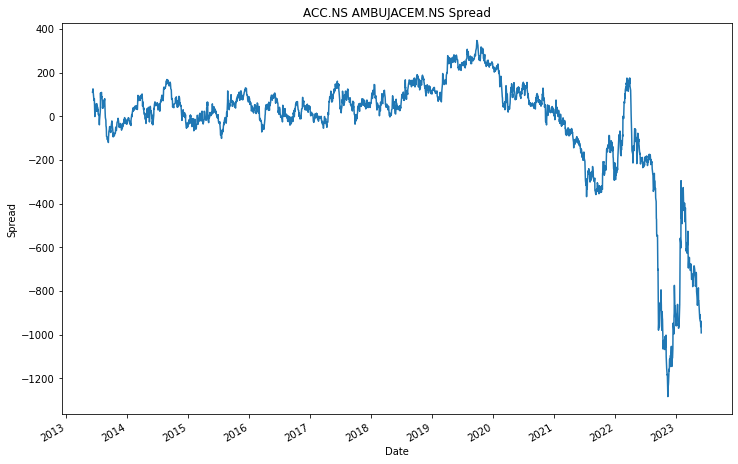

Total Strategy Returns are:  57.62
Sharpe Ratio is: 0.85


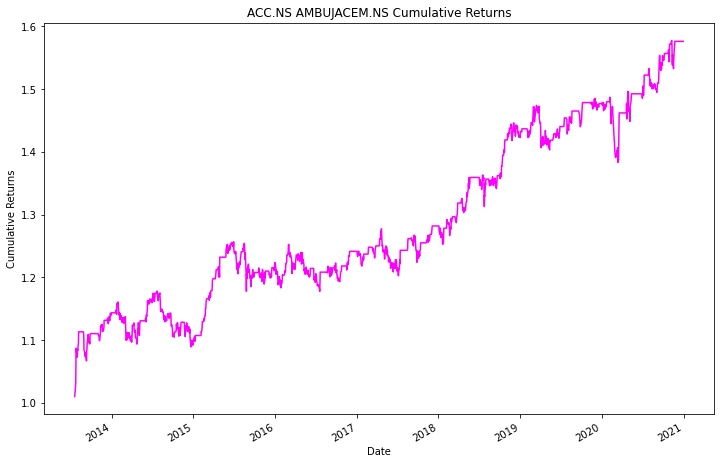

Start date,2013-06-07
End date,2020-12-31
Total months,88
,Backtest
Annual return,6.3%
Cumulative returns,57.6%
Annual volatility,7.7%
Sharpe ratio,0.85
Calmar ratio,0.84
Stability,0.93
Max drawdown,-7.6%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


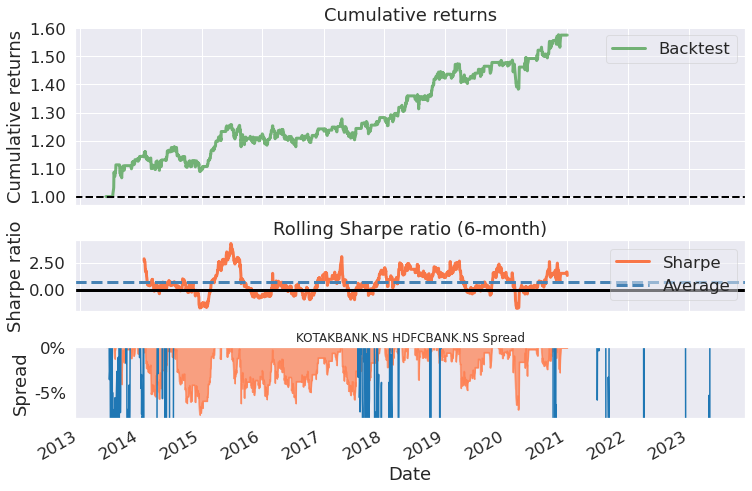

Total Strategy Returns are:  145.93
Sharpe Ratio is: 1.34


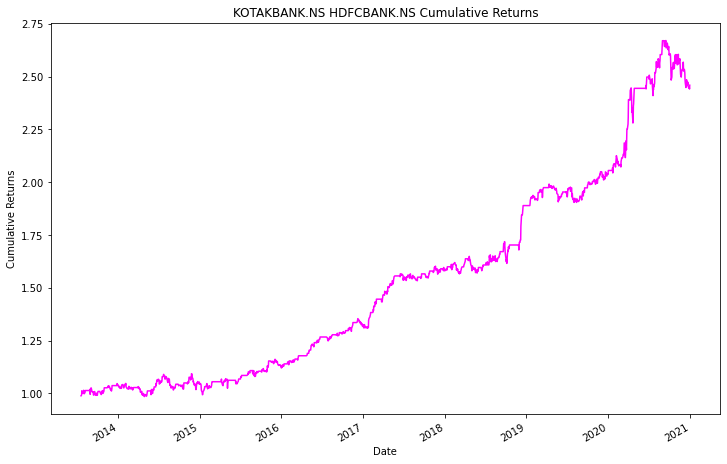

Start date,2013-06-07
End date,2020-12-31
Total months,88
,Backtest
Annual return,12.9%
Cumulative returns,145.9%
Annual volatility,9.6%
Sharpe ratio,1.34
Calmar ratio,1.42
Stability,0.96
Max drawdown,-9.1%


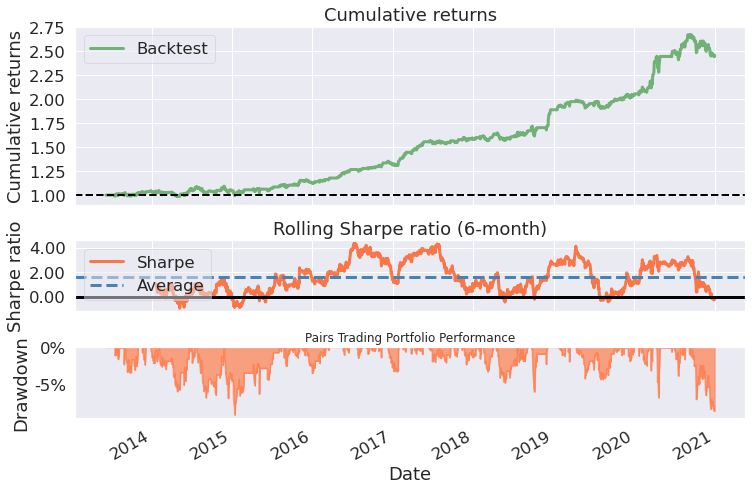

Porfolio Performance:  99.58


Start date,2013-06-07
End date,2020-12-31
Total months,88
,Backtest
Annual return,9.8%
Cumulative returns,99.6%
Annual volatility,6.2%
Sharpe ratio,1.57
Calmar ratio,1.36
Stability,0.97
Max drawdown,-7.2%


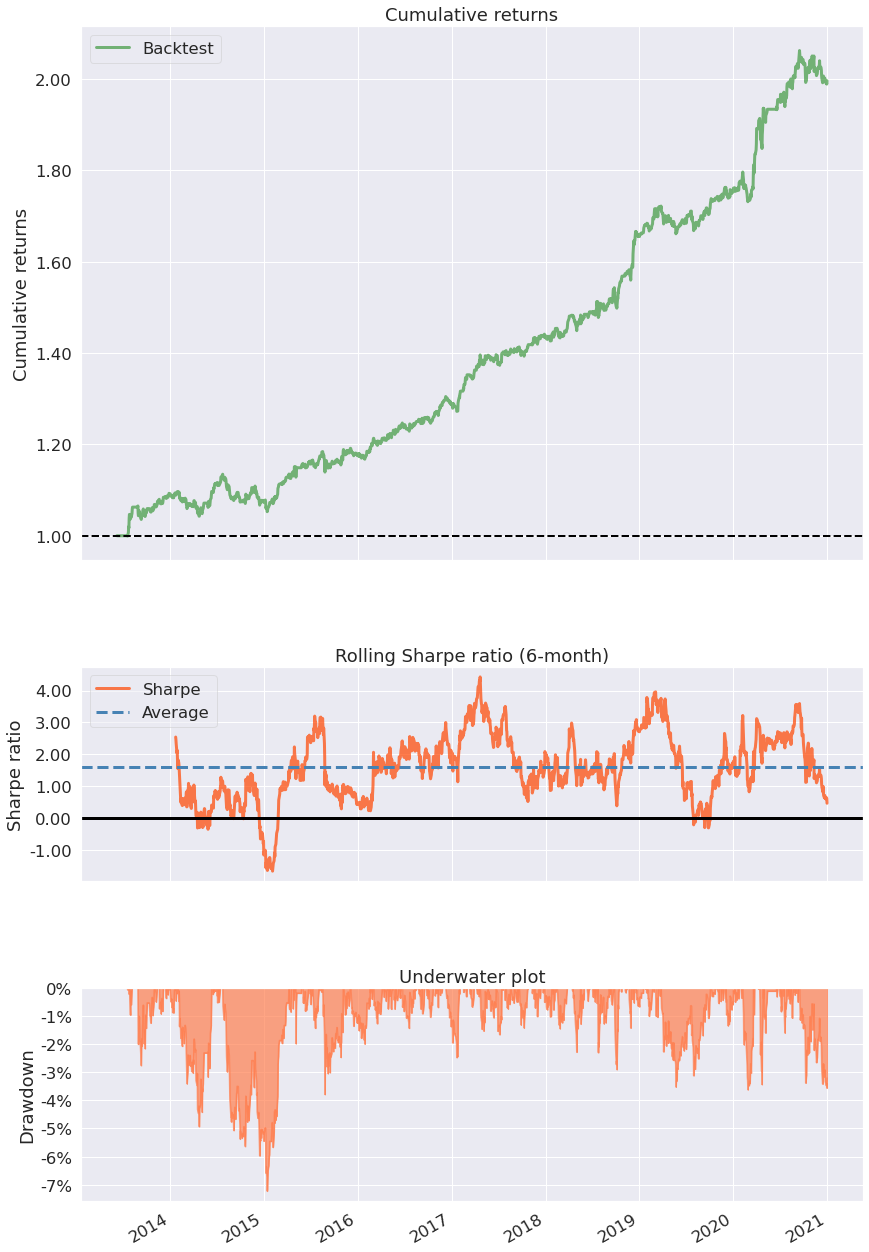

In [9]:
pairs_trading_backtest()

In [10]:
# trading the pairs in a portfolio increased the sharpe ratio, decreased the drawdown. But returns also became lower in comparison to returns from pair2